In [3]:
# ============================================================
# Token-CNN + MetaOptNet-Ridge  (Step 2: DRUG-CLASS setting with K=5, Q=10 and λ-sweep)
# ============================================================
import os, random, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ---------------- DRUG-CLASS CONFIG ----------------
CSV_PATH       = "megares_fasta_processed.csv"
LABEL_COL      = "drug_class"     # <--- changed to drug_class
N, K, Q        = 3, 5, 10         # <--- more shots & queries
MIN_VAL_CLS    = 8
MIN_TEST_CLS   = 8
MIN_COUNT_BASE = 20               # <--- ensure >= K+Q and a margin
KMER_K         = 5
MAX_LEN        = 512
LR             = 2e-4
EPISODES       = 1400
EVAL_EVERY     = 20
PATIENCE       = 20
RANDOM_SEED    = 42
L2_GRID        = [1e-4, 5e-4, 1e-3, 2e-3, 5e-3]  # <--- ridge λ sweep
# ---------------------------------------------------

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================
# 1) Load & clean
# =========================
df = pd.read_csv(CSV_PATH)
assert "sequence" in df.columns and LABEL_COL in df.columns
df = df.dropna(subset=["sequence", LABEL_COL]).reset_index(drop=True)
df["sequence"] = df["sequence"].str.upper().str.replace(r"[^ACGT]", "", regex=True)
print(f"Raw unique {LABEL_COL}s:", df[LABEL_COL].nunique())

# =========================
# 2) Filter by MIN_COUNT
# =========================
MIN_COUNT = max(K + Q, MIN_COUNT_BASE)
counts = df[LABEL_COL].value_counts()
keep_labels = counts[counts >= MIN_COUNT].index
df = df[df[LABEL_COL].isin(keep_labels)].reset_index(drop=True)
print("Filtered dataset:", df.shape)
print(f"Filtered unique {LABEL_COL}s:", df[LABEL_COL].nunique())

# Optional peek
if set(["group","mechanism","drug_class"]).issubset(df.columns):
    print(df[["group","mechanism","drug_class"]].drop_duplicates().head(10))

# =========================
# 3) Robust label split
# =========================
def robust_split_labels(all_labels, min_val=6, min_test=6, seed=42, max_tries=200):
    """
    Dynamically choose the holdout fraction so that val+test >= min_val+min_test.
    Then split holdout 50/50 (rounded).
    """
    rng = np.random.default_rng(seed)
    labs = np.array(sorted(all_labels))
    L = len(labs)

    need = min_val + min_test
    holdout = max(need, int(np.ceil(0.4 * L)))     # at least 40% or enough to meet need
    holdout = min(holdout, L - 3)                  # keep at least 3 train classes

    n_val = int(np.ceil(holdout / 2))
    n_test = holdout - n_val

    # ensure minimums
    n_val = max(n_val, min_val)
    n_test = max(n_test, min_test)
    if n_val + n_test >= L:
        # back off slightly if we took everything
        n_test = min_test
        n_val  = min_val

    for _ in range(max_tries):
        perm = rng.permutation(L)
        val_idx  = perm[:n_val]
        test_idx = perm[n_val:n_val+n_test]
        train_idx = perm[n_val+n_test:]
        if len(train_idx) >= 3:
            return labs[train_idx], labs[val_idx], labs[test_idx]

    raise RuntimeError("Could not find a split with the requested counts.")


labels_all = df[LABEL_COL].unique()
train_labels, val_labels, test_labels = robust_split_labels(
    labels_all, min_val=8, min_test=8, seed=RANDOM_SEED
)


train_df = df[df[LABEL_COL].isin(train_labels)].reset_index(drop=True)
val_df   = df[df[LABEL_COL].isin(val_labels)].reset_index(drop=True)
test_df  = df[df[LABEL_COL].isin(test_labels)].reset_index(drop=True)
print(f"Split (labels): train/val/test = {len(train_labels)}/{len(val_labels)}/{len(test_labels)}")
print(f"Split (samples): train/val/test = {len(train_df)}/{len(val_df)}/{len(test_df)}")

# =========================
# 4) Tokenization (train-only vocab)
# =========================
PAD, UNK = "<PAD>", "<UNK>"
def kmers_from_seq(seq, k=KMER_K):
    L = len(seq)
    if L < k: return []
    return [seq[i:i+k] for i in range(L-k+1)]

from collections import Counter
counter = Counter()
for s in train_df["sequence"]:
    counter.update(kmers_from_seq(s, KMER_K))

tokens = [PAD, UNK] + sorted(counter.keys())
stoi = {t: i for i, t in enumerate(tokens)}
VOCAB_SIZE = len(stoi)
print("Vocab size:", VOCAB_SIZE)

def encode_ids(seq):
    arr = kmers_from_seq(seq, KMER_K)
    if not arr: return [stoi[UNK]]
    return [stoi.get(tok, stoi[UNK]) for tok in arr]

def encode_df_to_ids(dfp):
    ids = [encode_ids(s) for s in dfp["sequence"].tolist()]
    nums = dfp[["gc_content", "seq_len"]].to_numpy(np.float32) if set(["gc_content","seq_len"]).issubset(dfp.columns) \
           else np.zeros((len(dfp),2), np.float32)
    y = dfp[LABEL_COL].to_numpy()
    return ids, nums, y

train_ids, train_num, ytr = encode_df_to_ids(train_df)
val_ids,   val_num,   yva = encode_df_to_ids(val_df)
test_ids,  test_num,  yte = encode_df_to_ids(test_df)

# =========================
# 5) Padding + RC augmentation
# =========================
def pad_sequences(list_of_ids, max_len=MAX_LEN, pad_id=None):
    if pad_id is None: pad_id = stoi[PAD]
    out = np.full((len(list_of_ids), max_len), pad_id, dtype=np.int64)
    for i, seq in enumerate(list_of_ids):
        s = seq[:max_len]
        out[i, :len(s)] = s
    return out

Xtr_tok = pad_sequences(train_ids, MAX_LEN)
Xva_tok = pad_sequences(val_ids,   MAX_LEN)
Xte_tok = pad_sequences(test_ids,  MAX_LEN)

_comp = str.maketrans("ACGT", "TGCA")
def rev_comp(seq): return seq.translate(_comp)[::-1]
train_ids_rc = [encode_ids(rev_comp(s)) for s in train_df["sequence"].tolist()]
Xtr_tok_rc   = pad_sequences(train_ids_rc, MAX_LEN)

# standardize numeric features (train stats only)
num_mean = train_num.mean(axis=0, keepdims=True)
num_std  = train_num.std(axis=0, keepdims=True) + 1e-6
train_num = (train_num - num_mean) / num_std
val_num   = (val_num   - num_mean) / num_std
test_num  = (test_num  - num_mean) / num_std

# =========================
# 6) Episodic sampler
# =========================
from collections import defaultdict
def index_by_label(y):
    d = defaultdict(list)
    for i, lab in enumerate(y): d[lab].append(i)
    return {k: np.asarray(v, dtype=int) for k, v in d.items()}

def _choose_tokens_with_rc(Xtok, Xtok_rc, ids, rng, rc_prob=0.25):
    if Xtok_rc is None or rc_prob <= 0: return Xtok[ids]
    mask = rng.random(len(ids)) < rc_prob
    out = Xtok[ids].copy()
    if mask.any(): out[mask] = Xtok_rc[ids[mask]]
    return out

def create_tasks(X_tok, X_num, y, idx_map,
                 num_tasks=1000, N=3, K=5, Q=10,
                 seed=42, X_tok_rc=None, rc_prob=0.25, augment_rc=False):
    rng = np.random.default_rng(seed)
    tasks, valid = [], [m for m, ids in idx_map.items() if len(ids) >= K + Q]
    if len(valid) < N: return tasks
    for _ in range(num_tasks):
        labs = rng.choice(valid, size=N, replace=False)
        s_tok, s_num, s_y, q_tok, q_num, q_y = [], [], [], [], [], []
        for j, m in enumerate(labs):
            ids = rng.choice(idx_map[m], size=K+Q, replace=False)
            s, q = ids[:K], ids[K:K+Q]
            if augment_rc and (X_tok_rc is not None):
                s_tok.append(_choose_tokens_with_rc(X_tok, X_tok_rc, s, rng, rc_prob))
                q_tok.append(_choose_tokens_with_rc(X_tok, X_tok_rc, q, rng, rc_prob))
            else:
                s_tok.append(X_tok[s]); q_tok.append(X_tok[q])
            s_num.append(X_num[s]); q_num.append(X_num[q])
            s_y.append(np.full(K, j, np.int64)); q_y.append(np.full(Q, j, np.int64))
        tasks.append({
            "s_tok": np.vstack(s_tok), "s_num": np.vstack(s_num), "s_y": np.concatenate(s_y),
            "q_tok": np.vstack(q_tok), "q_num": np.vstack(q_num), "q_y": np.concatenate(q_y),
            "labels": list(labs)
        })
    return tasks

idx_tr = index_by_label(ytr)
idx_va = index_by_label(yva)
idx_te = index_by_label(yte)

RC_PROB = 0.25
SUPPORT_DROP = 0.03
QUERY_DROP   = 0.01

train_tasks = create_tasks(Xtr_tok, train_num, ytr, idx_tr,
                           num_tasks=1500, N=N, K=K, Q=Q,
                           seed=RANDOM_SEED, X_tok_rc=Xtr_tok_rc, rc_prob=RC_PROB, augment_rc=True)
val_tasks   = create_tasks(Xva_tok,  val_num,  yva, idx_va,
                           num_tasks=300,  N=N, K=K, Q=Q, seed=RANDOM_SEED, augment_rc=False)
test_tasks  = create_tasks(Xte_tok,  test_num, yte, idx_te,
                           num_tasks=500,  N=N, K=K, Q=Q, seed=RANDOM_SEED, augment_rc=False)

print(f"Tasks | train:{len(train_tasks)} val:{len(val_tasks)} test:{len(test_tasks)} (N={N},K={K},Q={Q})")

def token_dropout(arr, p=0.0, pad_id=0):
    if p <= 0: return arr
    mask = (np.random.rand(*arr.shape) < p)
    out = arr.copy(); out[mask] = pad_id
    return out

# =========================
# 7) Encoder
# =========================
class CNNSeqEncoder(nn.Module):
    def __init__(self, vocab_size, pad_idx, max_len,
                 embed_dim=256, token_dim=128,
                 conv_channels=96, kernel_sizes=(3,5,7),
                 use_cosine=True, num_features=2):
        super().__init__()
        self.use_cosine = use_cosine
        self.emb = nn.Embedding(vocab_size, token_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(0.20)
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(token_dim, conv_channels, k, padding=k//2),
                nn.ReLU(),
                nn.Dropout1d(0.10)
            ) for k in kernel_sizes
        ])
        self.num_proj = nn.Sequential(nn.Linear(num_features, 32), nn.ReLU(), nn.BatchNorm1d(32))
        fused_in = conv_channels*len(kernel_sizes)*2 + 32
        self.proj = nn.Sequential(
            nn.Linear(fused_in, 512), nn.ReLU(), nn.BatchNorm1d(512), nn.Dropout(0.50),
            nn.Linear(512, embed_dim)
        )
        self.log_temp = nn.Parameter(torch.zeros(1))

    def forward(self, tokens, nums):
        x = self.emb(tokens); x = self.emb_dropout(x); x = x.transpose(1,2)
        pooled = []
        for block in self.convs:
            h = block(x)
            pooled.extend([F.adaptive_max_pool1d(h,1).squeeze(-1),
                           F.adaptive_avg_pool1d(h,1).squeeze(-1)])
        h_text = torch.cat(pooled, dim=1)
        h_num  = self.num_proj(nums)
        z = self.proj(torch.cat([h_text, h_num], dim=1))
        if self.use_cosine: z = F.normalize(z, p=2, dim=1)
        return z

# =========================
# 8) MetaOptNet ridge head + eval
# =========================
def metaoptnet_ridge_head(s_z, s_y, q_z, l2_reg=1e-3):
    device = s_z.device
    S, d = s_z.shape
    C = int(s_y.max().item()) + 1
    Y = F.one_hot(s_y, num_classes=C).float()
    regI = l2_reg * torch.eye(d, device=device)
    A = s_z.t() @ s_z + regI
    B = s_z.t() @ Y
    W = torch.linalg.solve(A, B)
    logits = q_z @ W
    return logits, W

@torch.no_grad()
def evaluate_metaoptnet(model, tasks, device, l2_reg=1e-3):
    model.eval()
    accs, losses = [], []
    for t in tasks:
        s_tok = torch.from_numpy(t["s_tok"]).long().to(device)
        s_num = torch.from_numpy(t["s_num"]).float().to(device)
        q_tok = torch.from_numpy(t["q_tok"]).long().to(device)
        q_num = torch.from_numpy(t["q_num"]).float().to(device)
        s_y   = torch.from_numpy(t["s_y"]).long().to(device)
        q_y   = torch.from_numpy(t["q_y"]).long().to(device)

        s_z = model(s_tok, s_num); q_z = model(q_tok, q_num)
        logits_q, _ = metaoptnet_ridge_head(s_z, s_y, q_z, l2_reg=l2_reg)
        loss = F.cross_entropy(logits_q, q_y)
        accs.append((logits_q.argmax(1) == q_y).float().mean().item())
        losses.append(loss.item())
    return float(np.mean(accs)), float(np.std(accs)), float(np.mean(losses))

# =========================
# 9) Training helper so we can sweep λ easily
# =========================
def train_once(l2_reg):
    model = CNNSeqEncoder(vocab_size=VOCAB_SIZE, pad_idx=stoi[PAD], max_len=MAX_LEN,
                          embed_dim=256, token_dim=128, conv_channels=96, kernel_sizes=(3,5,7),
                          use_cosine=True, num_features=2).to(device)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=2e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=800)

    best_val, bad = 0.0, 0
    train_losses, train_accs, val_accs = [], [], []
    PAD_ID = stoi[PAD]

    for ep in tqdm(range(1, EPISODES+1), leave=False):
        model.train()
        t = random.choice(train_tasks)
        t_s_tok = token_dropout(t["s_tok"], p=0.03, pad_id=PAD_ID)
        t_q_tok = token_dropout(t["q_tok"], p=0.01, pad_id=PAD_ID)
        s_tok = torch.from_numpy(t_s_tok).long().to(device)
        s_num = torch.from_numpy(t["s_num"]).float().to(device)
        q_tok = torch.from_numpy(t_q_tok).long().to(device)
        q_num = torch.from_numpy(t["q_num"]).float().to(device)
        s_y   = torch.from_numpy(t["s_y"]).long().to(device)
        q_y   = torch.from_numpy(t["q_y"]).long().to(device)

        opt.zero_grad()
        s_z = model(s_tok, s_num); q_z = model(q_tok, q_num)
        logits_q, _ = metaoptnet_ridge_head(s_z, s_y, q_z, l2_reg=l2_reg)
        loss = F.cross_entropy(logits_q, q_y)
        loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step(); sched.step()
        train_losses.append(loss.item())

        with torch.no_grad():
            model.log_temp.data.clamp_(-3.0, 0.5)

        if ep % EVAL_EVERY == 0:
            tr_acc, tr_std, _ = evaluate_metaoptnet(model, train_tasks[:50], device, l2_reg=l2_reg)
            va_acc, va_std, _ = evaluate_metaoptnet(model, val_tasks,      device, l2_reg=l2_reg)
            train_accs.append(tr_acc); val_accs.append(va_acc)

            if va_acc > best_val:
                best_val, bad = va_acc, 0
                torch.save(model.state_dict(), f"best_metaoptnet_cnn_{LABEL_COL}.pt")
            else:
                bad += 1
            if bad >= PATIENCE:
                break

    # reload best and test
    model.load_state_dict(torch.load(f"best_metaoptnet_cnn_{LABEL_COL}.pt", map_location=device))
    test_acc, test_std, test_loss = evaluate_metaoptnet(model, test_tasks, device, l2_reg=l2_reg)
    return best_val, test_acc, test_std, test_loss

# =========================
# 10) Run λ sweep
# =========================
results = []
print("\n=== Ridge λ sweep (drug_class) ===")
for lam in L2_GRID:
    print(f"\n-- λ={lam:.1e} --")
    best_val, tacc, tstd, tloss = train_once(lam)
    print(f"best_val={best_val:.3f} | TEST acc={tacc:.3f} ± {tstd:.3f} | loss={tloss:.3f}")
    results.append((lam, best_val, tacc, tstd, tloss))

print("\nSummary (λ, best_val, test_acc, test_std, test_loss)")
for r in results:
    print(r)


Device: cuda
Raw unique drug_classs: 59
Filtered dataset: (8547, 9)
Filtered unique drug_classs: 26
          group                                          mechanism  \
0          A16S  Aminoglycoside-resistant_16S_ribosomal_subunit...   
12   AAC2-PRIME                Aminoglycoside_N-acetyltransferases   
19         AAC3                Aminoglycoside_N-acetyltransferases   
67   AAC3-PRIME                Aminoglycoside_N-acetyltransferases   
70   AAC6-PRIME                Aminoglycoside_N-acetyltransferases   
368        ABAF                         Fosfomycin_MFS_efflux_pump   
369        ABAQ                         Fosfomycin_MFS_efflux_pump   
370        ABCA                        Multi-drug_ABC_efflux_pumps   
371        ABEM                 Drug_and_biocide_MATE_efflux_pumps   
373        ABES                  Drug_and_biocide_SMR_efflux_pumps   

                      drug_class  
0                Aminoglycosides  
12               Aminoglycosides  
19               Aminogl

best_val=0.658 | TEST acc=0.605 ± 0.132 | loss=0.930

-- λ=5.0e-04 --


best_val=0.654 | TEST acc=0.616 ± 0.131 | loss=0.926

-- λ=1.0e-03 --


best_val=0.656 | TEST acc=0.614 ± 0.127 | loss=0.928

-- λ=2.0e-03 --


best_val=0.656 | TEST acc=0.623 ± 0.127 | loss=0.919

-- λ=5.0e-03 --


best_val=0.649 | TEST acc=0.612 ± 0.128 | loss=0.928

Summary (λ, best_val, test_acc, test_std, test_loss)
(0.0001, 0.6581111470858256, 0.6045333673357963, 0.13184800158346013, 0.9295198751688003)
(0.0005, 0.6535555923978488, 0.6159333676099777, 0.1310535012564464, 0.9264723933935165)
(0.001, 0.6558889264861743, 0.6142666999697686, 0.1274398229658632, 0.9282695868015289)
(0.002, 0.6558889242013296, 0.6234667009711266, 0.1266508131731539, 0.9191588078737258)
(0.005, 0.6491111486156782, 0.6118000348806382, 0.12750897956585036, 0.9277463479042053)


In [4]:
# ============================
# Final run (drug_class, λ = 2e-3) with training curves + plots
# ============================
L2_REG = 2e-3

best_val, test_acc, test_std, test_loss = train_once(L2_REG)
print(f"\nFINAL RUN (drug_class, λ={L2_REG})")
print(f"Best Val Acc: {best_val:.3f}")
print(f"Test  Acc: {test_acc:.3f} ± {test_std:.3f}")
print(f"Loss: {test_loss:.3f}")

# After that, load best model and create t-SNE etc.
model = CNNSeqEncoder(vocab_size=VOCAB_SIZE, pad_idx=stoi[PAD], max_len=MAX_LEN,
                      embed_dim=256, token_dim=128, conv_channels=96, kernel_sizes=(3,5,7),
                      use_cosine=True, num_features=2).to(device)
model.load_state_dict(torch.load(f"best_metaoptnet_cnn_{LABEL_COL}.pt", map_location=device))

# Now reuse your t-SNE + clustering diagnostics code from earlier (MetaOptNet group run)
# e.g. the block starting with:
# "from sklearn.manifold import TSNE"
# and printing silhouette, ARI, NMI, Inter/Intra ratio + t-SNE scatter



FINAL RUN (drug_class, λ=0.002)
Best Val Acc: 0.636
Test  Acc: 0.620 ± 0.131
Loss: 0.923


<All keys matched successfully>


=== t-SNE Diagnostic Summary (drug_class) ===
Points: 800 | Classes: 8
Silhouette: -0.273 | ARI: 0.056 | NMI: 0.173 | Inter/Intra: 1.13


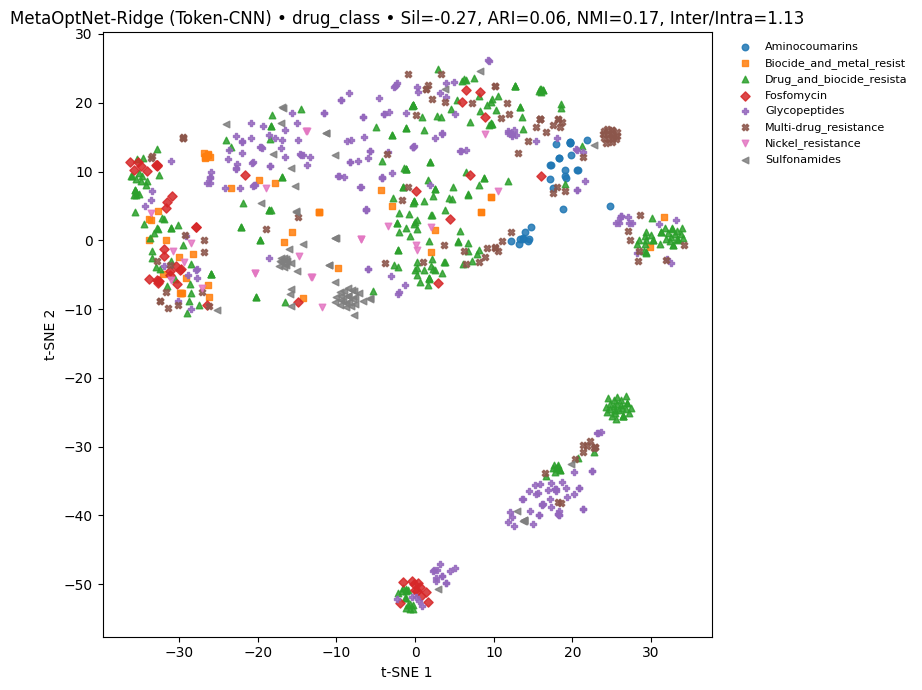

In [6]:
# ============================
# t-SNE + clustering diagnostics for MetaOptNet-Ridge (drug_class)
# ============================
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# --- compatibility wrapper: works no matter how encode_ids was defined ---
def encode_ids_compat(seq):
    try:
        return encode_ids(seq, KMER_K)   # version that accepts (seq, k)
    except TypeError:
        return encode_ids(seq)           # version that only accepts (seq)

# --- helper: embed a dataframe with the SAME pipeline used at train time ---
def embed_df(df_sample, model, n_max=800, label_col=LABEL_COL, seed=42):
    model.eval()
    df_sample = df_sample.sample(min(n_max, len(df_sample)), random_state=seed).reset_index(drop=True)

    # tokens
    ids = [encode_ids_compat(s) for s in df_sample["sequence"].tolist()]
    tok = np.full((len(ids), MAX_LEN), stoi[PAD], dtype=np.int64)
    for i, seq in enumerate(ids):
        s = seq[:MAX_LEN]
        tok[i, :len(s)] = s

    # numeric features (standardize with train stats)
    nums = df_sample[["gc_content", "seq_len"]].to_numpy(np.float32)
    nums = (nums - num_mean) / num_std

    with torch.no_grad():
        Xt = torch.from_numpy(tok).long().to(device)
        Xn = torch.from_numpy(nums).float().to(device)
        Z  = model(Xt, Xn).detach().cpu().numpy()

    labels = df_sample[label_col].values
    return Z, labels

# --- collect embeddings from TEST set (cap to keep t-SNE fast) ---
Z, y_str = embed_df(test_df, model, n_max=800, label_col=LABEL_COL)

# --- t-SNE ---
TSNE_PERPLEX = 30
perplexity = min(TSNE_PERPLEX, max(5, len(Z)//4 - 1))
tsne = TSNE(n_components=2, perplexity=perplexity, init="pca", learning_rate="auto", random_state=42)
Z2 = tsne.fit_transform(Z)

# --- clustering diagnostics in 2D t-SNE space ---
unique_labels = np.unique(y_str)
lab2id = {lab:i for i,lab in enumerate(unique_labels)}
y = np.array([lab2id[l] for l in y_str], dtype=int)

sil = silhouette_score(Z2, y) if len(unique_labels) > 1 else float("nan")
kmeans = KMeans(n_clusters=len(unique_labels), n_init="auto", random_state=42)
pred = kmeans.fit_predict(Z2)
ari = adjusted_rand_score(y, pred)
nmi = normalized_mutual_info_score(y, pred)

D = pairwise_distances(Z2, metric="euclidean")
intra = [D[i, y == y[i]].mean() for i in range(len(Z2))]
inter = [D[i, y != y[i]].mean() for i in range(len(Z2))]
mean_intra = float(np.nanmean(intra))
mean_inter = float(np.nanmean(inter))
ratio = mean_inter / (mean_intra + 1e-9)

print("\n=== t-SNE Diagnostic Summary (drug_class) ===")
print(f"Points: {len(Z2)} | Classes: {len(unique_labels)}")
print(f"Silhouette: {sil:.3f} | ARI: {ari:.3f} | NMI: {nmi:.3f} | Inter/Intra: {ratio:.2f}")

# --- plot ---
plt.figure(figsize=(9,7))
markers = ["o","s","^","D","P","X","v","<",">","*"]
for i,lab in enumerate(unique_labels):
    idx = (y_str == lab)
    plt.scatter(Z2[idx,0], Z2[idx,1], s=22, alpha=0.85, marker=markers[i % len(markers)], label=str(lab)[:24])
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.title(f"MetaOptNet-Ridge (Token-CNN) • drug_class • Sil={sil:.2f}, ARI={ari:.2f}, NMI={nmi:.2f}, Inter/Intra={ratio:.2f}")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", fontsize=8, frameon=False)
plt.tight_layout(); plt.show()


                     drug_class  n_queries  n_correct  accuracy
0                Aminocoumarins       2140       1988  0.928972
1                  Sulfonamides       2250       1527  0.678667
2                    Fosfomycin       2180       1372  0.629358
3  Biocide_and_metal_resistance       2210       1343  0.607692
4             Nickel_resistance       2390       1322  0.553138
5         Multi-drug_resistance       2250       1234  0.548444
6                 Glycopeptides       2260       1189  0.526106
7   Drug_and_biocide_resistance       2320       1011  0.435776


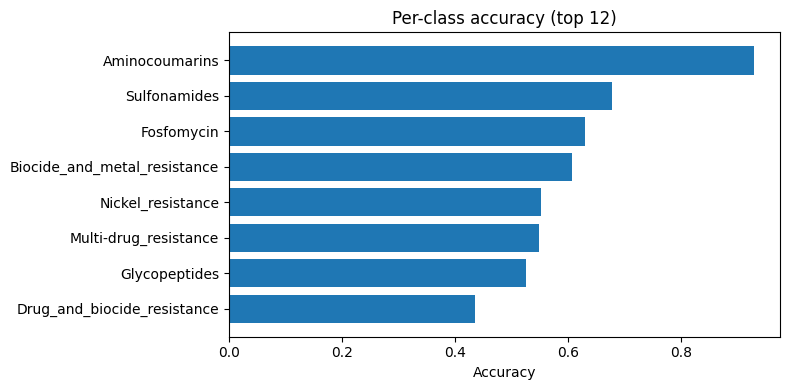

In [8]:
# ============================
# Per-class accuracy on fresh TEST episodes (drug_class)
# ============================
from collections import defaultdict
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- compatibility wrapper so this works with either encode_ids(seq) or encode_ids(seq, k)
def encode_ids_compat(seq):
    try:
        return encode_ids(seq, KMER_K)   # if your encode_ids accepts (seq, k)
    except TypeError:
        return encode_ids(seq)           # if it only accepts (seq)

def metaoptnet_ridge_logits(s_z, s_y, q_z, l2_reg=2e-3):
    # s_z: [S,d], s_y: [S], q_z:[Q,d], labels in {0..C-1}
    C = int(s_y.max().item()) + 1
    Y = F.one_hot(s_y, num_classes=C).float()
    Z = s_z
    d = Z.shape[1]
    A = Z.t() @ Z + l2_reg * torch.eye(d, device=Z.device)
    B = Z.t() @ Y
    W = torch.linalg.solve(A, B)             # [d,C]
    return q_z @ W                           # [Q,C]

@torch.no_grad()
def per_class_acc(model, label_col=LABEL_COL, N=3, K=5, Q=10, num_tasks=600, seed=123):
    rng = np.random.default_rng(seed)

    # Build an index for TEST set by label
    d = defaultdict(list)
    for i, lab in enumerate(test_df[label_col].values):
        d[lab].append(i)
    idx_map = {k: np.asarray(v, dtype=int) for k,v in d.items() if len(v) >= K+Q}
    labels = list(idx_map.keys())

    # storage
    correct = defaultdict(int)
    total   = defaultdict(int)

    for _ in range(num_tasks):
        if len(labels) < N: break
        chosen = rng.choice(labels, size=N, replace=False)

        s_tok_list, s_num_list, s_y_list = [], [], []
        q_tok_list, q_num_list, q_y_list = [], [], []

        # build one episode
        for j, lab in enumerate(chosen):
            ids = rng.choice(idx_map[lab], size=K+Q, replace=False)
            s, q = ids[:K], ids[K:K+Q]

            # encode tokens
            def _pad_take(rows):
                arr = np.full((len(rows), MAX_LEN), stoi[PAD], dtype=np.int64)
                for r_i, rid in enumerate(rows):
                    seq = test_df.iloc[rid]["sequence"]
                    ids2 = encode_ids_compat(seq)      # <-- FIXED HERE
                    s2 = ids2[:MAX_LEN]
                    arr[r_i, :len(s2)] = s2
                return arr

            s_tok = _pad_take(s); q_tok = _pad_take(q)
            s_num = test_df.iloc[s][["gc_content","seq_len"]].to_numpy(np.float32)
            q_num = test_df.iloc[q][["gc_content","seq_len"]].to_numpy(np.float32)
            s_num = (s_num - num_mean) / num_std
            q_num = (q_num - num_mean) / num_std

            s_tok_list.append(s_tok); q_tok_list.append(q_tok)
            s_num_list.append(s_num); q_num_list.append(q_num)
            s_y_list.append(np.full(K, j, np.int64))
            q_y_list.append(np.full(Q, j, np.int64))

        # stack
        s_tok = torch.from_numpy(np.vstack(s_tok_list)).long().to(device)
        q_tok = torch.from_numpy(np.vstack(q_tok_list)).long().to(device)
        s_num = torch.from_numpy(np.vstack(s_num_list)).float().to(device)
        q_num = torch.from_numpy(np.vstack(q_num_list)).float().to(device)
        s_y   = torch.from_numpy(np.concatenate(s_y_list)).long().to(device)
        q_y   = torch.from_numpy(np.concatenate(q_y_list)).long().to(device)

        # embeddings + episode head
        s_z = model(s_tok, s_num); q_z = model(q_tok, q_num)
        logits = metaoptnet_ridge_logits(s_z, s_y, q_z, l2_reg=2e-3)
        preds  = logits.argmax(dim=1).cpu().numpy()
        truth  = q_y.cpu().numpy()

        # map episode-local ids back to real label strings
        chosen = list(chosen)  # array -> list for indexing
        for p,t in zip(preds, truth):
            total[chosen[t]]   += 1
            correct[chosen[t]] += int(p == t)

    rows = []
    for lab in sorted(total.keys(), key=lambda k: correct[k]/max(total[k],1), reverse=True):
        acc = correct[lab] / max(total[lab], 1)
        rows.append((lab, total[lab], correct[lab], acc))
    df_pc = pd.DataFrame(rows, columns=["drug_class","n_queries","n_correct","accuracy"])
    print(df_pc.head(12))

    # quick plot (top 12)
    top = df_pc.head(12)
    plt.figure(figsize=(8,4))
    plt.barh(top["drug_class"], top["accuracy"])
    plt.gca().invert_yaxis()
    plt.xlabel("Accuracy")
    plt.title("Per-class accuracy (top 12)")
    plt.tight_layout()
    plt.show()

    # try to show a spreadsheet view if available
    try:
        import caas_jupyter_tools as cj
        cj.display_dataframe_to_user("Per-class accuracy (drug_class)", df_pc)
    except Exception:
        pass
    return df_pc

# run it
df_perclass = per_class_acc(model, label_col=LABEL_COL, N=3, K=5, Q=10, num_tasks=600)
